ZeroDivisionError: float division by zero

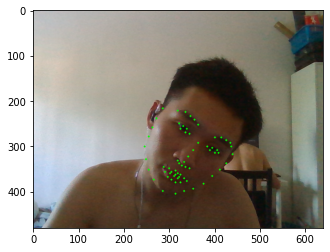

In [5]:
## Code Here
import os
import cv2 as cv
import torch
from face_alignment import FaceAlignment
from face_alignment import LandmarksType
from preprocessData import preprocess

def capture_n_display():
    cap = cv.VideoCapture(0)

    # Face detector option can be blazeface, sfd, or dlib (must install with visual studio C++)
    model = FaceAlignment(landmarks_type= LandmarksType.TWO_D, face_detector='blazeface', face_detector_kwargs={'back_model': True},device='cpu')
    total_frames = int (5*30)
    frames = [None]*total_frames
    count = 0 
    while count < total_frames:
        ret, frame = cap.read()
        frames[count] = frame
        count += 1
        cv.imshow('OpenCv',frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()
    return frames

def selectFrame(frames):
    return [frames[i] for i in range(0,150,7)]

def saveFramestoFiles(frames):
    if not os.path.exists("rawFrames"):
        os.mkdir("rawFrames")    

    for i in range(len(frames)):
        cv.imwrite(f'{"rawFrames"}\selectedFrames_{i}.png', frames[i])

if __name__ == '__main__':
    # Prompt Start Option
    # Get the video frames of pain 

    while(True):	

        start = True if (str(input("Start? (Y/n) :"))).lower() == "y" else False

        if (start):
            frames = capture_n_display()
            frames = selectFrame(frames)
            saveFramestoFiles(frames)
            break
    
    # Preprocess each frame
    preprocess(frames)
    


In [4]:
import math
from face_alignment import FaceAlignment
from face_alignment import LandmarksType
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from PIL import Image

class preprocess():
    def __init__(self, frames):
        super(preprocess, self).__init__()
        self.frames = frames 
        self.frames = self.landmarkDetection()
        self.tiltAlign()
    
    def landmarkDetection(self):
        frames = self.frames
        output = []
        framesLandmark=[]
        model = FaceAlignment(landmarks_type= LandmarksType.TWO_D, face_detector='blazeface', face_detector_kwargs={'back_model': True},device='cpu')
        for n in range(0, len(frames)):
            img = (frames[n])
            img = img.copy()
            landmarks = model.get_landmarks(img)
            landmarks_tuple=[]
            if landmarks is not None:
                        # Iterate over the detected faces
                        for pred in landmarks:
                            # Draw landmarks on the frame
                            for point in pred:
                                x, y = point
                                landmarks_tuple.append((int(x),int(y)))
                                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                                    cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

            framesLandmark.append(landmarks_tuple)
            output.append(img)
        self.framesLandmark = framesLandmark
        return output

    def tiltAlign(self):
         frames = self.frames
         for i in range(len(frames)):
              img = frames[i]
              landmarkTuple = self.framesLandmark[i]
              # Landmark index of reight eye and left eye are
              right_eye_cood = [landmarkTuple[40][0]-landmarkTuple[37][0],landmarkTuple[40][1]-landmarkTuple[37][1]]
              left_eye_cood = [landmarkTuple[46][0]-landmarkTuple[43][0],landmarkTuple[46][1]-landmarkTuple[43][1]]
              x1,y1 = right_eye_cood
              x2,y2 = left_eye_cood
              
              a = y1-y2
              b = x2-x1
              c = math.sqrt(a*a + b*b)
              
              print(a,b,c)

              cos_alpha = (b*b + c*c -a*a)/(2*b*c)

              alpha = np.arccos(cos_alpha)
              alpha = (alpha * 180)/math.pi
              aligned_img = Image.fromarray(img)
              aligned_img = np.array(aligned_img.rotate(alpha))
              plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

